# Cервис аренды самокатов GoFast

# Описание проекта
**Популярный сервис аренды самокатов GoFast.**  <br>
Представлены данные о некоторых пользователях из нескольких городов, а также об их поездках. 
 
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. <br>
Сервисом можно пользоваться:<br>
- без подписки  
 - абонентская плата отсутствует;  
 - стоимость одной минуты поездки — 8 рублей;
 - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
 - абонентская плата — 199 рублей в месяц;
 - стоимость одной минуты поездки — 6 рублей;
 - стоимость старта — бесплатно.<br>
<br>

# Задача
Проанализировать данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.<br> 

In [1]:
# Загрузим необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from scipy.stats import binom
from math import factorial
pd.set_option('display.max_rows', None)

## Шаг 1. Загрузка данных

In [2]:
try:
    users_go = pd.read_csv(r'C:\goFast\users_go.csv')
    rides_go = pd.read_csv(r'C:\goFast\rides_go.csv',)
    subscrip_go = pd.read_csv(r'C:\goFast\subscriptions_go.csv')
except:
    users_go = pd.read_csv('/datasets/users_go.csv')
    rides_go = pd.read_csv('/datasets/rides_go.csv')
    subscrip_go = pd.read_csv('/datasets/subscriptions_go.csv')

### Описание данных

In [3]:
display(users_go.head(2))

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra


`user_id`	уникальный идентификатор пользователя  
`name`	имя пользователя  
`age`	возраст  
`city`	город  
`subscription_type`	тип подписки (free, ultra)  

In [4]:
users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
display(rides_go.head(2))

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18


`user_id`	уникальный идентификатор пользователя  
`distance`	расстояние, которое пользователь проехал в текущей сессии (в метрах)  
`duration`	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку»  
до момента, как он нажал кнопку «Завершить поездку»  
`date`	дата совершения поездки  

In [6]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [7]:
display(subscrip_go.head(2))

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


`subscription_type`	тип подписки  
`minute_price`	стоимость одной минуты поездки по данной подписке  
`start_ride_price`	стоимость начала поездки  
`subscription_fee`	стоимость ежемесячного платежа

In [8]:
subscrip_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


## Шаг 2. Предобработка данных

Рассмотрев информацию о данных можно определить, что тип date необходимо преобразовать в `datetime[]`.

In [9]:
rides_go['date'] = pd.to_datetime(rides_go['date'], format='%Y-%m-%d')

In [10]:
display(rides_go.sample(2))

,user_id,distance,duration,date
3646,393,2525.378573,14.313446,2021-01-13
2024,219,3372.267826,15.493929,2021-01-02


Проведем округление значений столбцов `distance` и `duration` до целых.

In [11]:
# для корректности округления применим ceil, а так же поменят тип данных.
rides_go['distance'] = np.ceil(rides_go['distance']).astype(int)
rides_go['duration'] = np.ceil(rides_go['duration']).astype(int)

In [12]:
rides_go.sample(10)
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  int32         
 2   duration  18068 non-null  int32         
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(2), int64(1)
memory usage: 423.6 KB


### Создаем новый столбец с номером месяца.

In [13]:
rides_go['month'] = rides_go['date'].dt.month

### Пропуски

In [14]:
display(users_go.isnull().sum())
display(rides_go.isna().sum())
display(subscrip_go.isna().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропусков нет.  
  
### Дубликаты  
Рассмотрим явные и не явные дубликаты.  
  
#### Явные дубликаты:

In [15]:
display(users_go.duplicated().sum())
display(rides_go.duplicated().sum())
display(subscrip_go.duplicated().sum())

31

0

0

в данных user_go присутсвуют явные дубликаты 31 раз. рассмотрим их и примем решение удалять их или нет.

In [16]:
users_go[users_go.duplicated()].head()

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free


In [17]:
# Удалим их, но оставим первое значение и обновим индексы.
users_go.drop_duplicates().reset_index(drop=True).sample(10)

,user_id,name,age,city,subscription_type
627,628,Александр,23,Екатеринбург,ultra
197,198,Марсель,27,Сочи,ultra
281,282,Захар,33,Краснодар,ultra
1335,1336,Роман,20,Тюмень,free
963,964,Юлия,32,Тюмень,free
357,358,Екатерина,29,Москва,ultra
180,181,Денис,32,Омск,ultra
405,406,Валерия,31,Москва,ultra
314,315,Игорь,13,Москва,ultra
707,708,Святогор,24,Пятигорск,free


#### Неявные дубликаты.

In [18]:
# рассмотрим уникальные значения и, если находим неявные дубликаты будем исправлять.
users_go['user_id'].unique()

array([   1,    2,    3, ..., 1532, 1533, 1534], dtype=int64)

In [19]:
users_go['name'].unique()

array(['Кира', 'Станислав', 'Алексей', 'Константин', 'Адель', 'Регина',
       'Игорь', 'Юрий', 'Ян', 'Валерий', 'Агата', 'Марк', 'Ева',
       'Антонина', 'Валерия', 'Амалия', 'Даниил', 'Аделина', 'Святогор',
       'Борис', 'Вероника', 'Ростислав', 'Назар', 'Эдуард', 'Василий',
       'Денис', 'Тамара', 'Николай', 'Эвелина', 'Федор', 'Руслан', 'Иван',
       'Любовь', 'Ярослава', 'Майя', 'Ильдар', 'Данила', 'Нина',
       'Стефания', 'Ясмина', 'Дмитрий', 'Александр', 'Одиссей', 'Арсений',
       'Алла', 'Таисия', 'Максим', 'Юлиана', 'Павел', 'Карина', 'Алиса',
       'Лидия', 'Рамиль', 'Родион', 'Ника', 'Оксана', 'Анастасия',
       'Маргарита', 'Вера', 'Тимур', 'Никита', 'Лев', 'Влад', 'Артур',
       'Анна', 'Ольга', 'Вячеслав', 'Ксения', 'Виталина', 'Владислав',
       'Тамерлан', 'Амина', 'Вадим', 'Олеся', 'Зарина', 'Егор', 'Гордей',
       'Лилия', 'Святослав', 'Роберт', 'Амир', 'Влада', 'Богдан',
       'Полина', 'Марат', 'Елисей', 'Макар', 'Алина', 'Глеб', 'Андрей',
       'Ал

Наташа и Наталья, Влад и Владислав одинаковые имена, сделаем замену на Наталью и Владислава. Остальные имена 

In [20]:
users_go['name'] = users_go['name'].replace({'Наташа':'Наталья', 'Влад': 'Владислав'})

In [21]:
users_go['age'].unique()

array([22, 31, 20, 26, 28, 25, 23, 21, 18, 27, 24, 29, 32, 14, 19, 30, 17,
       12, 35, 33, 13, 15, 37, 16, 34, 38, 36, 39, 43], dtype=int64)

In [22]:
rides_go['user_id'].unique()

array([   1,    2,    3, ..., 1532, 1533, 1534], dtype=int64)

In [23]:
rides_go['distance'].unique()

array([4410, 2618,  755, ...,  843, 4552, 1035])

In [24]:
rides_go['duration'].unique()

array([26, 16,  7, 19, 27, 17, 15, 24, 18, 10, 25, 12, 21, 14, 13, 22, 20,
       23, 28, 36, 34, 11,  6, 31, 33,  8, 29, 39, 32, 30,  9,  5, 37, 35,
       40, 38, 41,  4,  1,  3])

In [25]:
rides_go['date'].nunique()

364

`rides_go['month']` - создали ранее, нет необходимости проверять на дубликаты.  
`subscrip_go`- нет необходимости проверять на дубликаты. Датафрейм имеет всего 2 строки.

В предобработке данных проделали следующее:<br>
- преобразовали тип данных столбца date, distance и duration. 
- округлили данные в столбцах distance и duration.
- рассмотрели наличие пропусков (оказалось их нет)
- рассмотрели и исключили дубликаты (были явные и неявные дубликаты в именах в таблице users_go).

## Шаг 3. Исследовательский анализ данных

In [26]:
# создадим функцию для построения визуализаций.
def plotter(data,x,y, title, xlable, ylable, agg):
    unit = data.loc[data[x].notna(), [y, x]] \
                .groupby(y) \
                .agg([agg])
    unit.columns = unit.columns.get_level_values(1)
    unit = unit.sort_values(agg, ascending = False)
    ax = unit.plot.bar(figsize=(12,5),color='lightgreen')
    plt.title(title)
    plt.xlabel(xlable)
    plt.ylabel(ylable)
    plt.show()
    print(unit)


### частота встречаемости городов

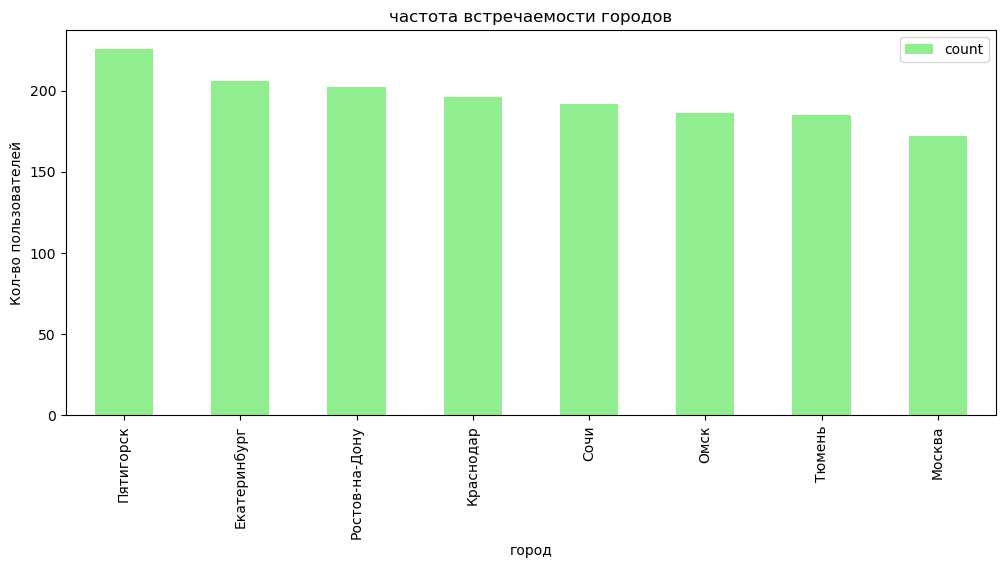

                count
city                 
Пятигорск         226
Екатеринбург      206
Ростов-на-Дону    202
Краснодар         196
Сочи              192
Омск              186
Тюмень            185
Москва            172


In [27]:
plotter (users_go,'user_id','city','частота встречаемости городов','город','Кол-во пользователей','count')

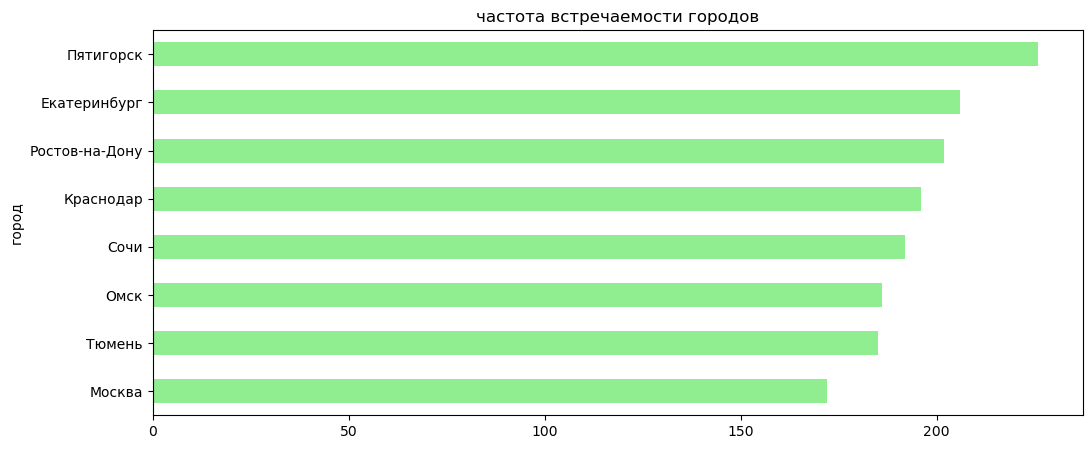

In [28]:
# Для сравнения
(users_go.groupby('city')['user_id']
    .agg('count')
    .sort_values(ascending = True)
    .plot.barh(figsize=(12,5),color='lightgreen',
            title ='частота встречаемости городов',
            xlabel='город',
            ylabel='Кол-во пользователей'
            ));

Спрос на самокаты самый большой в Пятигорске (226 человек), в Москве - самый маленький (172 человека).  
  
### соотношение пользователей с подпиской и без подписки

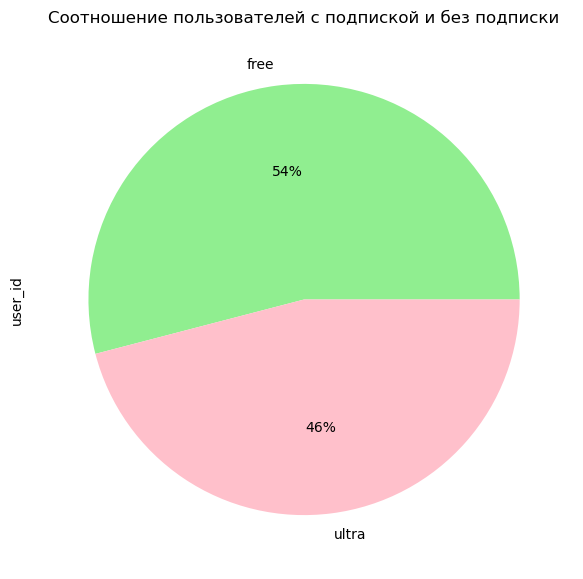

In [29]:
(
    users_go.groupby('subscription_type')['user_id']
        .count()
        .sort_values(ascending = False)
        .plot(
            kind = 'pie', 
            autopct = '%1.0f%%', 
            figsize=(7,7),
            title = 'Cоотношение пользователей с подпиской и без подписки',
            colors = ['lightgreen', 'pink']
             ));

Пользователи охотнее берут самокаты без подписки (54%).  
  
### возраст пользователей

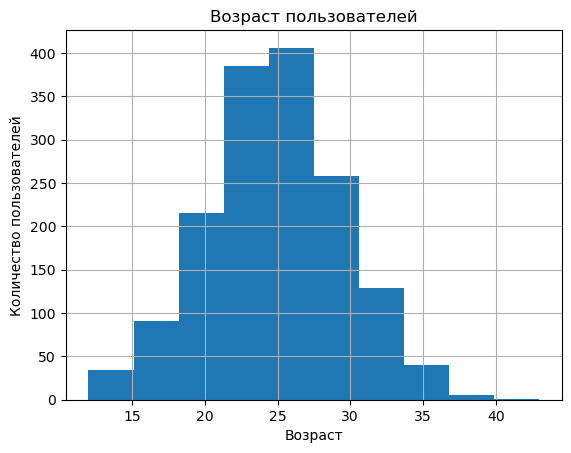

In [30]:
plt.hist(users_go['age'], bins = 10)
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()

Больше берут самокаты пользователи с возрастом 25 лет. Пользователи за 35 лет берут очень редко.  
  
###  расстояние, которое пользователь преодолел за одну поездку

In [31]:
unit = rides_go.loc[rides_go['distance'].notna(), ['user_id', 'distance']] \
                .groupby('user_id') \
                .agg(['median'])
print(round(unit.median()))
print('максимальное расстояние поездки',max(rides_go['distance']), 'метр(ов)')
print('минимальное расстояние поездки',min(rides_go['distance']), 'метр(ов)')

distance  median    3132.0
dtype: float64
максимальное расстояние поездки 7212 метр(ов)
минимальное расстояние поездки 1 метр(ов)


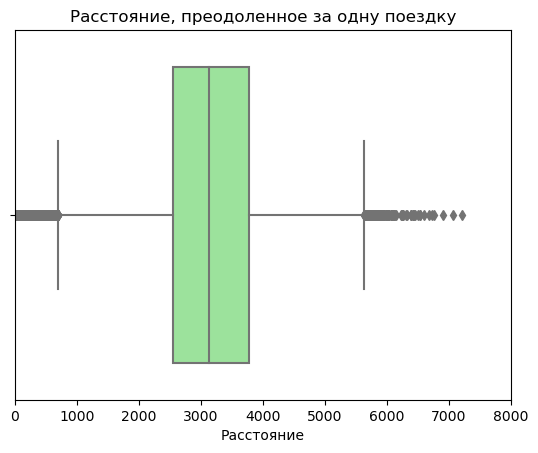

In [32]:
sns.boxplot(x=rides_go['distance'], color = 'lightgreen')
plt.title('Расстояние, преодоленное за одну поездку')
plt.xlabel('Расстояние')
plt.xlim(0, 8000);

Среднее расстояние одной поездки составляет 3132 м.  
  
### продолжительность поездок

In [33]:
unit = rides_go.loc[rides_go['duration'].notna(), ['user_id', 'duration']] \
                .groupby('user_id') \
                .agg(['median'])
print(round(unit.median(),2))
print('максимальная продолжительность поездки',max(rides_go['duration']), 'минут')
print('минимальная продолжительность поездки',min(rides_go['duration']), 'минут')

duration  median    18.0
dtype: float64
максимальная продолжительность поездки 41 минут
минимальная продолжительность поездки 1 минут


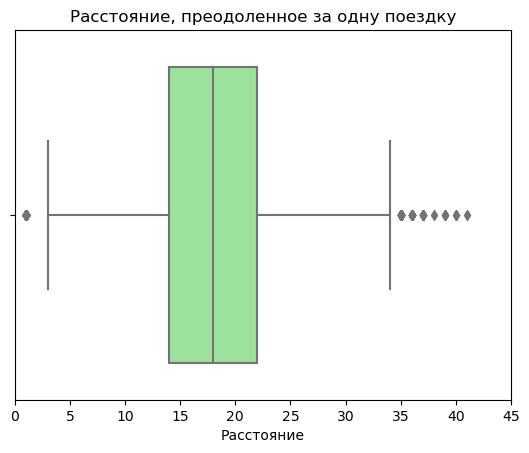

In [34]:
sns.boxplot(x=rides_go['duration'], color = 'lightgreen')
plt.title('Расстояние, преодоленное за одну поездку')
plt.xlabel('Расстояние')
plt.xlim(0, 45);

Средняя продолжительность одной поездки составляет 18 минут

## Шаг 4. Объединение данных  
  
### Объединение данных о пользователях, поездках и подписках в один датафрейм. 

In [35]:
users_go.info()
rides_go.info()
subscrip_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  int32         
 2   duration  18068 non-null  int32         
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), int32(2), int64(2)
memory usage: 564.8 KB
<class 'pandas.

users_go 1565 строк
rides_go 18068 строк
subscrip_go 2 строки
логичнее присоединять к таблице с большим количеством строк

In [36]:
# обьединяем так, что бы не потерять ни одной строки данных.
# обьединяем пользоватлей и поездки по столбцу "идентификатор пользователей"
data = users_go.merge(rides_go,on='user_id', )
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18388 entries, 0 to 18387
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18388 non-null  int64         
 1   name               18388 non-null  object        
 2   age                18388 non-null  int64         
 3   city               18388 non-null  object        
 4   subscription_type  18388 non-null  object        
 5   distance           18388 non-null  int32         
 6   duration           18388 non-null  int32         
 7   date               18388 non-null  datetime64[ns]
 8   month              18388 non-null  int64         
dtypes: datetime64[ns](1), int32(2), int64(3), object(3)
memory usage: 1.3+ MB


Очевидно, что были задублированны строки при соединении. Проверим предложение.

In [37]:
display(data.duplicated().sum())

320

In [38]:
data = data.drop_duplicates().reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  int32         
 6   duration           18068 non-null  int32         
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
dtypes: datetime64[ns](1), int32(2), int64(3), object(3)
memory usage: 1.1+ MB


In [39]:
# обьединяем пользоватлей с user_id и поездки по столбцу "стоимость ежемесячного платежа"
data = data.merge(subscrip_go, on= 'subscription_type')

In [40]:
# Проверим корректность обьединения.
display(data.sample(6))
print(data.info())

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
7485,770,Снежана,27,Краснодар,free,4039,26,2021-08-06,8,8,50,0
16138,1399,Лидия,28,Ростов-на-Дону,free,2451,18,2021-06-19,6,8,50,0
11247,1047,Дмитрий,23,Сочи,free,233,5,2021-08-28,8,8,50,0
15706,1370,Мирон,33,Москва,free,3301,22,2021-02-04,2,8,50,0
7660,783,Эдуард,20,Краснодар,free,3012,16,2021-06-27,6,8,50,0
2074,223,Игорь,25,Тюмень,ultra,2458,20,2021-04-10,4,6,0,199


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  int32         
 6   duration           18068 non-null  int32         
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), int32(2), int64(6), object(3)
memory usage: 1.7+ MB
None


In [41]:
display(data.duplicated().sum())

0

После обьединения дубликатов нет. Число строк совпадает и изначальным. Теперь можно работать дальше.

### Создание датафрейма c данными о пользователях без подписки

In [42]:
free_data = data[data['subscription_type'] == 'free'].copy()

In [43]:
display(free_data.sample(10))
free_data.info()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
10912,1022,Антонина,14,Сочи,free,4013,20,2021-07-17,7,8,50,0
8548,852,Альбина,20,Москва,free,1009,10,2021-01-13,1,8,50,0
13215,1191,Арсений,30,Ростов-на-Дону,free,3866,18,2021-07-13,7,8,50,0
9627,932,Антон,25,Сочи,free,3019,19,2021-02-01,2,8,50,0
15734,1372,Святослав,28,Краснодар,free,3583,10,2021-03-31,3,8,50,0
8381,839,Эвелина,25,Краснодар,free,3623,24,2021-04-28,4,8,50,0
8454,845,Всеволод,27,Краснодар,free,3417,16,2021-12-01,12,8,50,0
15091,1322,Ярослава,23,Тюмень,free,4191,14,2021-10-28,10,8,50,0
8588,855,Савелий,24,Пятигорск,free,2299,14,2021-10-14,10,8,50,0
14555,1284,Кирилл,28,Екатеринбург,free,4081,21,2021-06-24,6,8,50,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   name               11568 non-null  object        
 2   age                11568 non-null  int64         
 3   city               11568 non-null  object        
 4   subscription_type  11568 non-null  object        
 5   distance           11568 non-null  int32         
 6   duration           11568 non-null  int32         
 7   date               11568 non-null  datetime64[ns]
 8   month              11568 non-null  int64         
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), int32(2), int64(6), object(3)
memory usage: 1.1+ MB


### Создание с данными о пользователях с подпиской

In [44]:
ultra_data = data[data['subscription_type'] == 'ultra'].copy()

In [45]:
display(ultra_data.sample(10))
ultra_data.info()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
2111,226,Макар,21,Омск,ultra,3027,19,2021-01-13,1,6,0,199
1617,174,Инна,28,Краснодар,ultra,4810,21,2021-07-26,7,6,0,199
1163,125,Андрей,20,Тюмень,ultra,2155,19,2021-02-01,2,6,0,199
3456,372,Арсен,26,Ростов-на-Дону,ultra,3924,18,2021-07-03,7,6,0,199
3418,369,Ариана,22,Екатеринбург,ultra,3496,22,2021-02-03,2,6,0,199
4153,448,Мария,22,Москва,ultra,2738,23,2021-07-27,7,6,0,199
1161,124,Регина,29,Краснодар,ultra,2799,14,2021-12-30,12,6,0,199
5642,601,Платон,32,Тюмень,ultra,2858,16,2021-10-21,10,6,0,199
3527,379,Айдар,27,Ростов-на-Дону,ultra,4338,18,2021-08-11,8,6,0,199
4341,467,Евгения,17,Екатеринбург,ultra,3080,21,2021-08-31,8,6,0,199


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   int32         
 6   duration           6500 non-null   int32         
 7   date               6500 non-null   datetime64[ns]
 8   month              6500 non-null   int64         
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), int32(2), int64(6), object(3)
memory usage: 609.4+ KB


In [46]:
11568 +6500

18068

При формировании двух таблиц ни одной строки не было потеряно из изначальной.

### Информация о расстоянии и времени поездок для пользователей обеих категорий.

In [47]:
print(
round(free_data.loc[free_data['distance'].notna(), ['user_id', 'distance','duration']] \
                .groupby('user_id') \
                .agg(['median'])
                .median())
     )
print('максимальное расстояние поездки', max(free_data['distance']), 'метр(ов)')
print('минимальное расстояние поездки',min(free_data['distance']), 'метр.')
print('максимальная продолжительность поездки',max(free_data['duration']), 'минут.')
print('минимальная продолжительность поездки',min(free_data['duration']), 'минута.')

distance  median    3113.0
duration  median      18.0
dtype: float64
максимальное расстояние поездки 7212 метр(ов)
минимальное расстояние поездки 1 метр.
максимальная продолжительность поездки 35 минут.
минимальная продолжительность поездки 1 минута.


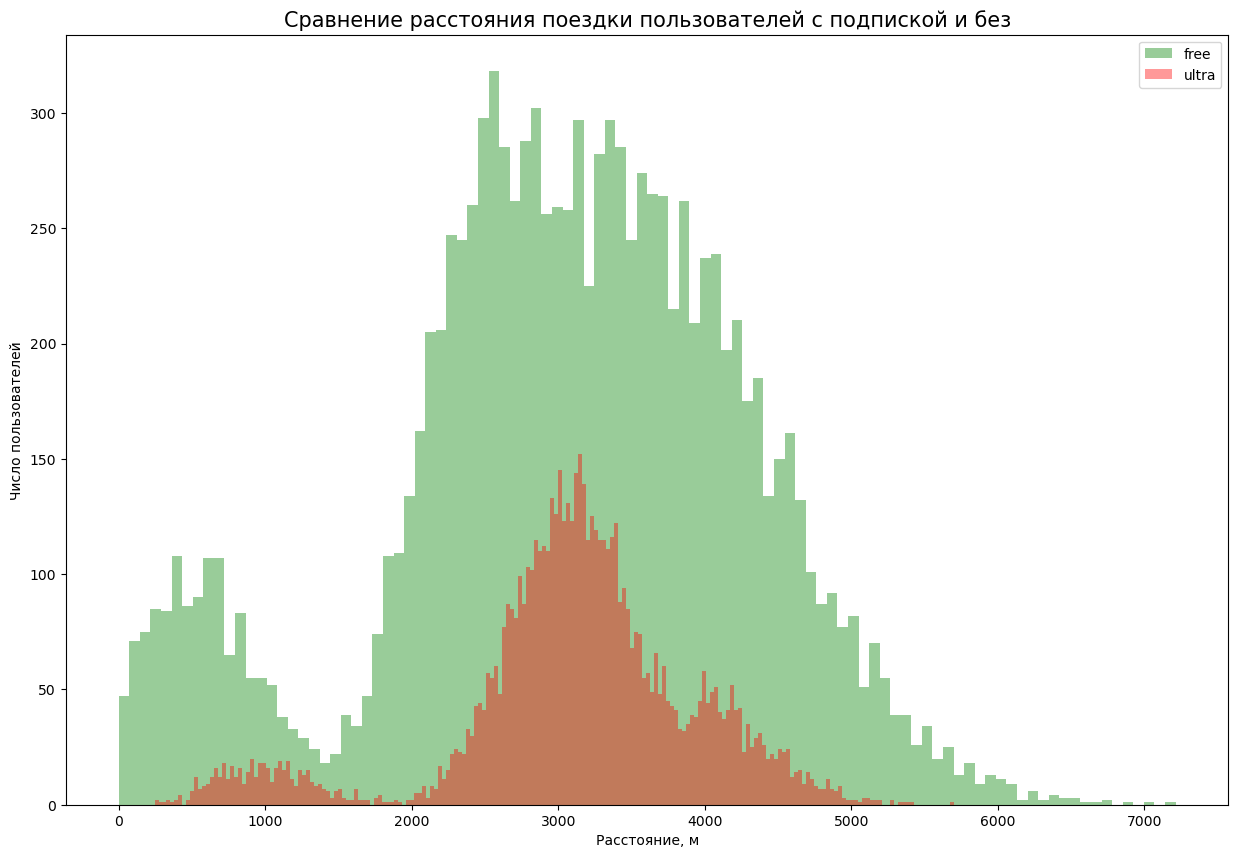

In [48]:
plt.figure(figsize=(15,10))

ax1 = free_data['distance'].plot(kind='hist', 
                                 bins = 100,
                                 color='g',
                                 alpha=0.4)

#отобразим график количества всех сообщений в зависимости от часа
ax2 = ultra_data['distance'].plot(kind='hist',
                                  bins = 200,
                                  color='r',
                                  alpha=0.4,
                                  ax=ax1)
plt.legend(['free', 'ultra'])
plt.xlabel('Расстояние, м')
plt.ylabel('Число пользователей')
plt.title('Сравнение расстояния поездки пользователей с подпиской и без', fontsize=15);

In [49]:
print(
round(ultra_data.loc[ultra_data['duration'].notna(), ['user_id', 'distance','duration']] \
                .groupby('user_id') \
                .agg(['median'])
                .median())
                
    )
print('максимальное расстояние поездки', max(ultra_data['distance']), 'метр(ов).')
print('минимальное расстояние поездки',min(ultra_data['distance']), 'метр(ов).')
print('максимальная продолжительность поездки',max(ultra_data['duration']), 'минут.')
print('минимальная продолжительность поездки',min(ultra_data['duration']), 'минуты.')

distance  median    3143.0
duration  median      19.0
dtype: float64
максимальное расстояние поездки 5700 метр(ов).
минимальное расстояние поездки 245 метр(ов).
максимальная продолжительность поездки 41 минут.
минимальная продолжительность поездки 4 минуты.


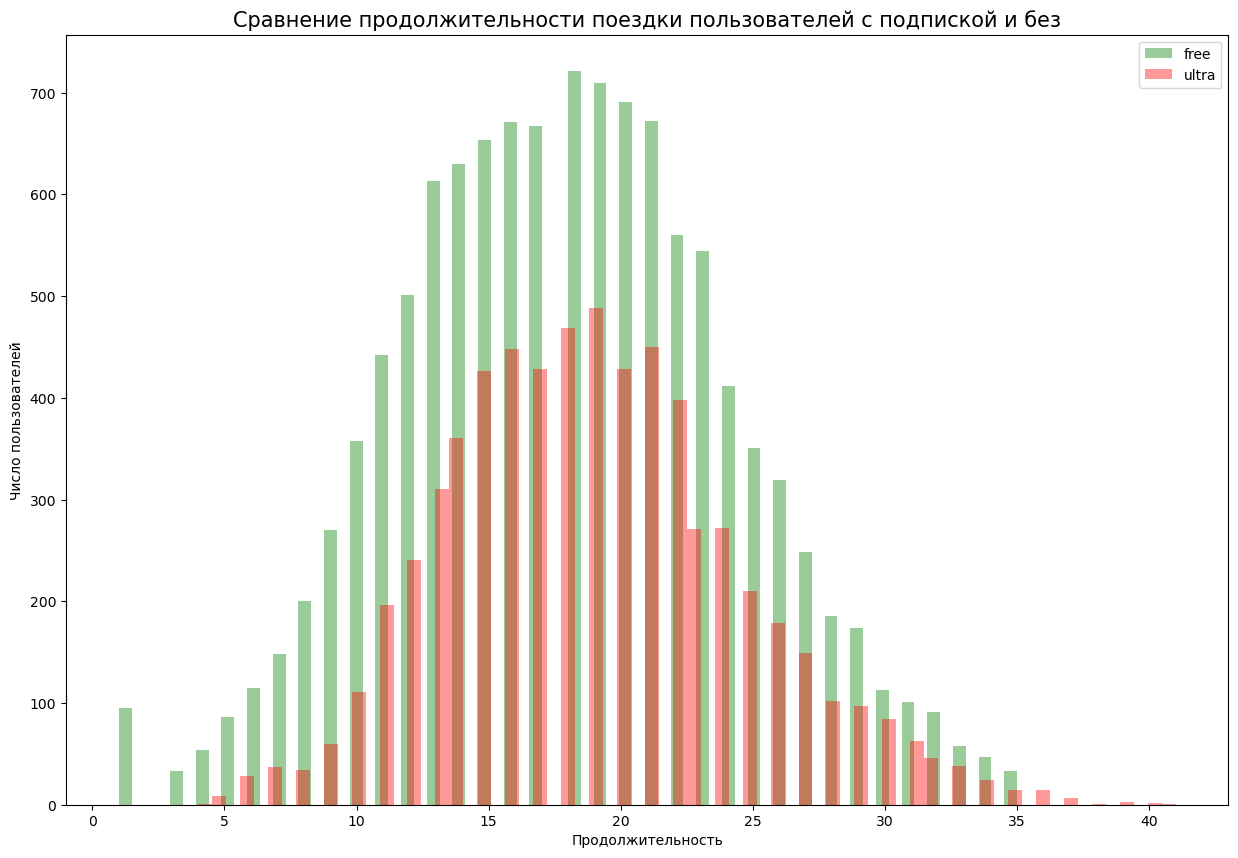

In [50]:
plt.figure(figsize=(15,10))

ax1 = free_data['duration'].plot(kind='hist', 
                                 bins = 70,
                                 color='g',
                                 alpha=0.4)

#отобразим график количества всех сообщений в зависимости от часа
ax2 = ultra_data['duration'].plot(kind='hist',
                                  bins = 70,
                                  color='r',
                                  alpha=0.4,
                                  ax=ax1)
plt.legend(['free', 'ultra'])
plt.xlabel('Продолжительность')
plt.ylabel('Число пользователей')
plt.title('Сравнение продолжительности поездки пользователей с подпиской и без', fontsize=15);

В среднем пользователи с подпиской используют самокаты так же, как и без подписки.  
Однако максимальные и минимальные значения различаются:  
- Максимальное расстояние пользователей с подпиской на 21% меньше, а минимальное в 244 раз больше.
- По продолжительности с подпиской пользователи на 17% дольше, чем без подписки.

## Шаг 5. Подсчёт выручки

Создим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. 

In [51]:
# суммарное расстояние и время поездки посчитаем функцией sum к столбцу distance и duration
# количество поездок возьмем count от стоблбца name.
# добавим колонку subscription_type для дальнейшего расчета ежемесячной выручки.
sum_data = pd.pivot_table(data, 
                            index=['month', 'user_id'],
                            values = ['distance', 'name','duration', 'subscription_type'],
                            aggfunc = {'distance':sum,'name':len,'duration':sum,'subscription_type':max})
# поменяем названия колонок
sum_data = sum_data.rename(columns = {'distance':'total_distance', 'name' : 'trips','duration':'total_duration'})

In [52]:
sum_data.sample(5)

,,total_distance,total_duration,trips,subscription_type
month,user_id,,,,
7,346,2792,22,1,ultra
10,538,3033,16,1,ultra
4,222,2988,15,1,ultra
10,1201,9852,65,3,free
9,992,5483,34,2,free


Добавим столбец с помесячной выручкой, которую принёс каждый пользователь.

In [53]:
def gain (row):
    if row['subscription_type'] == 'free':
        return 8 * row['total_duration'] + 50 * row['trips']
    elif row['subscription_type'] == 'ultra':
        return 6 * row['total_duration'] + 199

In [54]:
sum_data['gain'] = sum_data.apply(gain, axis=1) # добавляем значения в столбец выручка "gain"
sum_data.sample(10)

,,total_distance,total_duration,trips,subscription_type,gain
month,user_id,,,,,
3,326,2786,23,1,ultra,337
10,617,3122,19,1,ultra,313
7,631,3470,21,1,ultra,325
9,1440,1470,10,1,free,130
5,81,3706,15,1,ultra,289
12,114,3263,23,1,ultra,337
4,1078,3448,17,1,free,186
6,1387,4803,18,1,free,194
4,1201,5423,21,2,free,268


## Шаг 6. Проверка гипотез

> Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.<br>

6.1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? <br>Если да, то пользователи с подпиской могут быть «выгоднее» для компании. <br><br>

Дано:<br>
H0: duration(ultra) = duration(free)<br>
H1: duration(ultra) > duration(free)<br>
Alfa = 0.05

In [55]:
alpha = 0.05 # уровень статистической значимости
# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(ultra_data['duration'], free_data['duration'], alternative='greater')

print('p-значение:', results.pvalue)

# если p-value окажется меньше него, отвергнем гипотезу
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 2.4959453720736625e-34
Отвергаем нулевую гипотезу


Проверили гипотезу. Отвергли гипотезу, что пользователи с подпиской тратят одинаковое время на поездки, чем пользователи без подписки.

6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. <br> Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.<br>
Дано:<br>
Н0: distance = 3130 метров <br>
Н1: distance > 3130 метров <br>
alfa = 0.05

In [56]:
interested_value = 3130
alpha = .05 # уровень статистической значимости
# проводим ttest для одной выборке, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_1samp(
    ultra_data['distance'], 
    interested_value,
    alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9120422337080507
Не получилось отвергнуть нулевую гипотезу


Проверили гипотезу. Отвергли гипотезу, что в среднем расстояние, которое проехали пользователи с подпиской превышает 3130 метров.

6.3. Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.<br>
Дано:<br>
Н0: выручка(gain)ultra = выручка(gain)free <br>
Н1: выручка(gain)ultra > выручка(gain)free <br>
alfa = 0.05

In [57]:
ultra_revenue = sum_data[sum_data['subscription_type']=='ultra']
free_revenue = sum_data[sum_data['subscription_type']=='free']
alpha = 0.05 # уровень статистической значимости
# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(ultra_revenue['gain'], 
                       free_revenue['gain'], 
                       alternative='greater')

print('p-значение:', results.pvalue)

# если p-value окажется меньше него, отвергнем гипотезу
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Проверили гипотезу. Отвергли гипотезу. Можно утверждать, что выручка с пользователей с подпиской не равна выручке пользователей без подписки.

6.4. Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение.<br> Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. <br>Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. <br>Какой тест вам понадобился бы для проверки этой гипотезы?<br>

Для данной задачи можно применить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок. <br>
<br>
H0 : μ1 = μ2 <br>
H1 : μ1 != μ2 <br>
alfa = 0.05 <br>
results = st.ttest_rel(before, after)

## Шаг 7. Распределения

### акция с раздачей промокодов
Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. <br>
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. <br> Определим какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. 
Подберем параметры распределения, описывающего эту ситуацию, и построим график распределения.

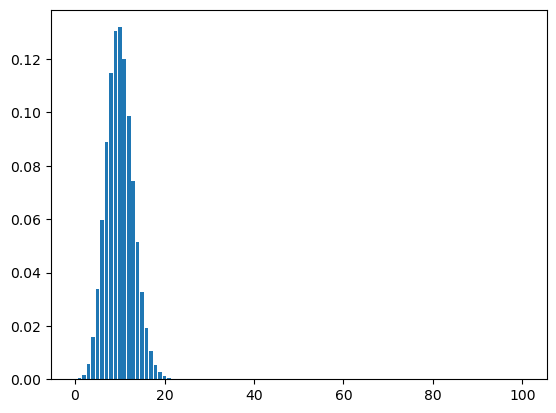

In [58]:
n = 100 # количество попыток
p = 0.1 # вероятность успеха

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
plt.bar(range(0, n + 1), distr);

График показывает, что при вероятности успеха p, равной 10% и 100 промокодов вероятность, что больше 22 клиентов продлят подписку, крайне мала. Посчитаем сколько промокодов необходимо разослать.

In [59]:
max_value = 100  # количество клиентов для продления подписки
p = 0.1  # Вероятность продления подписки

# Считаем промокоды - n
n = 0
while binom.cdf(max_value - 1, n, p) > 0.05:
    n += 1
    
print('Минимальное количество промокодов:', n)
print(f"Вероятность не выполнить план при таком количестве промокодов: {binom.cdf(max_value - 1, n, p):.2%}")

Минимальное количество промокодов: 1161
Вероятность не выполнить план при таком количестве промокодов: 4.98%


Построим график распределения

D:\Anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


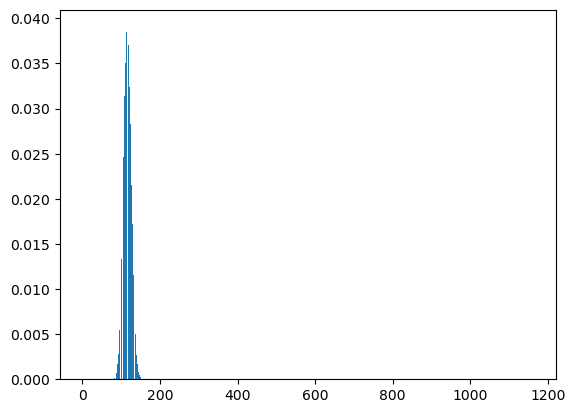

In [60]:
n = 1161 # количество попыток
p = 0.1 # Вероятность продления подписки

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
plt.bar(range(0, n + 1), distr);

График показывает, что если разослать 1161 промокод, то 100 клиентов (которые продлят подписку) - наиболее вероятный результат.

### рассылка клиентам push-уведомления
Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [61]:
from math import sqrt # загрузим sqrt из библиотеки math
n = 1000000
n1= 399500
p = 0.4
mu = n*p # мат ожидание 
sigma = sqrt(n * p * (1 - p)) # стандартное отклонение

distr = st.norm(mu, sigma)  # нормальное распределение

result = distr.cdf(n1)
print(f"вероятность того, что уведомление откроют не более 399,5 тыс. пользователей: {result:.2%}")

вероятность того, что уведомление откроют не более 399,5 тыс. пользователей: 15.37%


15.3% крайне маленькая вероятность.

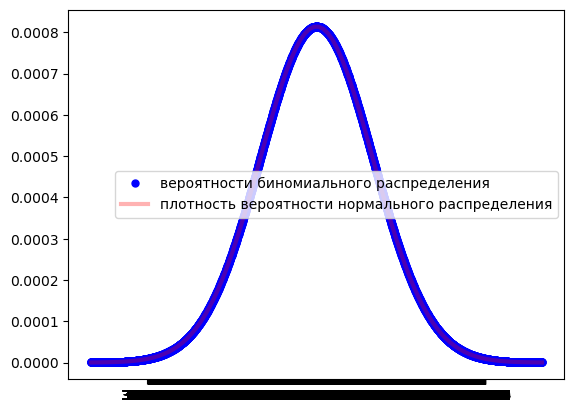

Условие выполняется


In [62]:
from scipy.stats import norm
# зададим функцию, которая выдаёт <num> чисел,
# равномерно распределённых от <start> до <stop>
# (понадобится для визуализации нормального распределения)
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result
# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))

# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))
# рисуем график биномиального распределения
ax = plt.subplot()
# используем синие о-образные маркеры и размер маркера 5
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=5,
	      label='вероятности биномиального распределения')
# рисуем график нормального распределения:
# получим список из 100 чисел от left до right
x = linspace(left, right, 100)
# используем красную линию ширины 3 и прозрачности 0.3
ax.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=3, alpha=0.3, label='плотность вероятности нормального распределения')
 
# зададим подписи по оси x в пределах ± 3 ст.отклонений от мат.ожидания
# (последний аргумент в методе range - интервал между подписями)
x_ticks = list(range(int(mu - 3 * sigma), int(mu + 3 * sigma), 1))
ax.set_xticks(x_ticks)

# настраиваем оптимальное расположение легенды и выводим график
ax.legend(loc='best')
plt.show()

# выводим, выполняется ли наше условие аппроксимации:
# лежит ли mu ± 3 sigma в промежутке от 0 до n:
if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):
    print('Условие выполняется')
else:
    print('Условие не выполняется')

## Выводы

**Проделанная работа:**
1. Загрузили датафреймы: 
    - информация о пользователях
    - информация о поездах
    - информация о тарифах
2. Проделали предобработу:
Проверили данные на пропуски и дубликаты.
Добавлими вспомогательный толбец для последующего анализа.
Поменяли тип данных.
3. Провели исследовательский анализ данных:
Спрос на самокаты по городам - самый большой в Пятигорске (226 человек), в Москве - самый маленький (172 человека).<br>
Пользователи охотнее берут самокаты без подписки.  ( 54% от всего количества пользователей. Без подписки `free` 846, С подпиской `ultra` 719).<br>
4. Определили возраст пользователей:
В возрастном диапазоне (с 25 по 43 года) пользователи чаще берут самокаты с 25 до 30 лет.<br>
~Один тряхнул стариной в 43 года~
5. Определили расстояние, которое проделали пользователи.
В среднем пользователи преодолевают 3132 м. Максимальное расстояние поездки 7212 метра, а минимальное - 1 метр. 
6. Определили время в пути, которое потратили пользователи.
Средняя продолжительность одной поездки составляет 18 минут. Максимальная продолжительность поездки 41 минут,а минимальная- 1 минута.
7. Объединили данные о пользователях, поездках и подписках в один датафрейм.<br>
На основе объединенного датафрейма создали еще датафреймы - пользователи с без подписки (free_data) и с подпиской (ultra_data).

8. Провели анализ о расстоянии и времени поездок для пользователей обеих категорий
- Пользователи **без подписки** <br>
в среднем проехали 3113 метров, в среднем потратили в дороге 18.0 минут.<br>
Максимальное расстояние поездки 7212 метров,минимальное - 1 метр.<br>
Максимальное продолжительность поездки 35 минут, минимальное 1 минута.
- Пользователи **с подпиской** <br>
в среднем проехали 3143 метров, , в среднем потратили в дороге 19.0 минут.<br>
Максимальное расстояние поездки 5700 минут, минимальное 245 метров.<br>
Максимальная продолжительность поездки 41 минута, минимальная 4 минуты.
9. Произвели подсчет выручки для каждого пользователя и добавили в датафрейм.
Больше всего потратил пользователь user_id 244 - 1952 рублей. 
10. Проверили гипотезы:<br>
- Тратят ли пользователи с подпиской больше времени на поездки, чем пользователи на бесплатном тарифе.<br>
Отвергли гипотезу, что пользователи с подпиской тратят одинаковое время на поездки, чем пользователи без подписки.<br>
- Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.<br>
Отвергли гипотезу, что в среднем расстояние, которое проехали пользователи с подпиской превышает 3130 метров..<br>
- Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.<br>
Отвергли гипотезу. Можно утверждать, что выручка с пользователей с подпиской не равна выручке пользователей без подписки..<br>
11. Рассмотрели распределения.
- Определили какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план(100 пользователей не продлили подписку) была примерно 5 %.
Необходимо разослать 1161 промокод, что бы 100 клиентов продлили подписку с шансом в 95%.
- Определили вероятность того, что уведомление откроют не более 399,5 тыс. пользователей, при условии, что отдел планирует разослать 1 млн уведомлений.<br>
Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей: 15.37%
<br>
 
**Рекомендации:**<br>
Для получения большей прибыли необходимо привлекать больше клиентов с подпиской, рассылая больше промокодов.